# RoPE

This experiment trains a GPT model with and without RoPE positional embeddings.

### Configure the machine and install packages


In [1]:
from typing import Literal
import sys

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken --quiet
    !pip uninstall -y tensorflow

Running on colab
Cloning into 'jaxpt'...
remote: Enumerating objects: 665, done.
remote: Counting objects: 100% (368/368), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 665 (delta 240), reused 212 (delta 138), pack-reused 297 (from 1)
Receiving objects: 100% (665/665), 26.37 MiB | 36.00 MiB/s, done.
Resolving deltas: 100% (390/390), done.
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:00
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )

sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/content/jaxpt/src


In [3]:
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np

os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)

os.environ.update({
  "NCCL_LL128_BUFFSIZE": "-2",
  "NCCL_LL_BUFFSIZE": "-2",
  "NCCL_PROTO": "SIMPLE,LL,LL128",
 })


# Hardware setup
print("JAX version:", jax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

REQUESTED_DEVICE = "gpu"

jax.config.update("jax_platform_name", REQUESTED_DEVICE) # Make sure we're using the GPU

device = jax.default_backend()
if device != REQUESTED_DEVICE:
    warnings.warn(f"not using {REQUESTED_DEVICE}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Makes sure the matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Available devices: 1
using gpu
797 µs ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the baseline and candidate models and perform a sanity check

In [4]:
from functools import partial

from flax import nnx

from jaxpt.infer import generate_completions
from jaxpt.models import RoPE_GPT, NoPE_GPT, RoPE_GPTConfig, NoPE_GPTConfig

"""
+--------------+---------+--------+------+
| Model        | Layers  | Heads  | Embd |
+--------------+---------+--------+------+
| gpt2-medium  | 24      | 16     | 1024 |
| gpt2-large   | 36      | 20     | 1280 |
| gpt2-xl      | 48      | 25     | 1600 |
+--------------+---------+--------+------+
"""

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
baseline_config = NoPE_GPTConfig(dtype=jnp.bfloat16, \
                   vocab_size=50257, \
                   sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(baseline_config)
candidate_config = RoPE_GPTConfig(dtype=jnp.bfloat16, \
                   vocab_size=50257, \
                   sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(candidate_config)
baseline = NoPE_GPT(baseline_config, rngs)
candidate = RoPE_GPT(candidate_config, rngs)

#m = load_checkpoint("run_20250311_uqdwjq", 5600)
graphdef, rngstate, state = nnx.split(baseline, nnx.RngState, ...)
nnx.display(state)
graphdef, rngstate, state = nnx.split(candidate, nnx.RngState, ...)
nnx.display(state)

#completions = generate_completions()
#for completion in completions:
#print(completion)


### Configure Logging and Checkpointing

In [5]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

baseline_run_dirname = f"baseline_run_{timestamp}_{random_code}"
print(f"Baseline Run: {baseline_run_dirname}")
candidate_run_dirname = f"candidate_run_{timestamp}_{random_code}"
print(f"Candidate Run: {candidate_run_dirname}")

if platform == "colab":
  output_dir = Path().absolute().parent
elif platform == "cuda":
  output_dir = Path("/home/ubuntu/gpt2-train") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent # Local setup

# Create checkpoint dir
checkpoint_dir = output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

# Create log dir
log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

Baseline Run: baseline_run_20250429_folboj
Candidate Run: candidate_run_20250429_folboj
Checkpoint directory: /checkpoints
Log directory: /logs


### Configure Training Run

In [14]:
import dataclasses

############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**15 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 32
  T: int = 1024
  max_steps: int = 19073 # 1 epoch (99 shards of the dataset should be around 18883, but Karpathy used 19073 for some reason)
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 715
  print_interval: int = 20
  eval_interval: int = 250
  checkpoint_interval: int = 250
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=16,
  T=32,
  max_steps=9*48*10, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=20,
  eval_interval=250,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps}")


tokens/batch: 32,768
block size: 1024
sub-batch size: 32
no. gradient accumulation steps: 1
effective batch size per device:  32
effective batch size: 32
max steps: 19073


### Configure the Baseline and Candidate Optimizer

In [7]:
import optax

# Set up the optimizer
def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

# Generate a weight decay mask
_, params, _ = nnx.split(baseline, nnx.Param, nnx.Variable)
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)
tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask)
)
baseline_optimizer = nnx.Optimizer(baseline, tx)

# count the number of weight decay params
def get_size(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(get_size, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)
print(f"baseline weight decay param count: {weight_decay_param_count:,}")


_, params, _ = nnx.split(candidate, nnx.Param, nnx.Variable)
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)
tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask)
)
candidate_optimizer = nnx.Optimizer(candidate, tx)

weight_decay_params = jax.tree_util.tree_map(get_size, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)

print(f"candidate weight decay param count: {weight_decay_param_count:,}")


baseline weight decay param count: 123,532,032
candidate weight decay param count: 123,532,032


### Configure DataLoader



In [15]:
import os
from google.cloud import storage

def is_folder_empty_or_missing(folder_path):
    """Check if the folder is missing or empty."""
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist.")
        return True
    if not os.path.isdir(folder_path):
        raise ValueError(f"{folder_path} exists but is not a folder!")
    if not any(os.scandir(folder_path)):
        print(f"Folder {folder_path} is empty.")
        return True
    return False

def download_gcs_bucket(bucket_name, destination_folder, folder_prefix=""):
    """Download all files from the GCS bucket to the destination folder."""
    # Initialize GCS client
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # List and download all blobs
    blobs = bucket.list_blobs(prefix=folder_prefix)
    for blob in blobs:
        dest_path = os.path.join(destination_folder, blob.name)
        if blob.name.endswith(".npz"):
            # Create destination directory if needed
            #os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            # Download blob
            print(f"Downloading {blob.name} to {dest_path}")
            blob.download_to_filename(dest_path)

In [16]:
from jaxpt.dataloaders import DataLoader
from jaxpt.eval import calc_validation_loss
from jaxpt.train import loss_fn

import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "alpha-448101-282bc1b884cd.json"

dataset = "fineweb-edu"
gcs_bucket = "jaxpt_datasets"
gcs_folder_prefix = "fineweb-edu/processed"

if platform == "colab":
    datasets_folder = Path().absolute() / "jaxpt" / "datasets"
elif platform == "cuda":
    datasets_folder = Path("/home/ubuntu/gpt2-train/")
else:
    datasets_folder = Path().absolute().parent / "datasets"

dataset_path = datasets_folder / dataset / "processed"

if is_folder_empty_or_missing(dataset_path):
    print("Folder is missing or empty. Downloading files from GCS...")
    os.makedirs(dataset_path, exist_ok=True)  # Create the folder if it didn't exist
    download_gcs_bucket(gcs_bucket, datasets_folder, folder_prefix=gcs_folder_prefix)



In [17]:
train_dl = DataLoader(dirpath=dataset_path,
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=num_devices,
                      label="train")
eval_dl = DataLoader(dirpath=dataset_path,
                     batch_size=trconf.mB,
                     block_size=trconf.T,
                     device_rank=1,
                     label="valid",
                     quiet=True)

def evaluate(model):
  model.eval()
  completions = generate_completions(model)
  val_loss = calc_validation_loss(model, loss_fn=loss_fn, dataloader=eval_dl)
  model.train()
  return val_loss, completions

step = 0

dataloader initialized:
------------------------
label:          train
shards:         99
shard size:     100,000,000
batch size:     32
block size:     1024
device rank:    1
------------------------


### Setup the Training Loop

0 | lr: 8.39e-07 | baseline loss: 10.9375 | candidate loss: 10.8750 | tokens processed: 32,768 | tok/sec: 62,557.70
baseline valid loss: 10.8750 |candidate valid loss: 10.8750 
Baseline completions:
Hello, I'm a language model, Causes Ö Gulfarin Tripoli ELECTluxundo forearm Nationals .porter
Hello, I'm a language model,CHAarin synerg shuts Dangerlikely certs synerg McKay Nicole Asgardting
Hello, I'm a language model,America Labor avoidsTrendenough extrapumbling jew Annie Annie authenticity civilians
Hello, I'm a language model, collabor Sly frontier frontier synerg9 Extension tonophon tools commuting sensitive
Hello, I'm a language model, correlation Obviously challengboxesakura MonitororfOrder Lei bombing bombingRIPT
Candidate completions
Hello, I'm a language model,fps hem369 Investors acre hints Austrian ideologically whiskey HOR rubbish clam
Hello, I'm a language model, poorertry MEP nefariousleaning qualify ant Greatestexamination Ottoman QUEST GPS
Hello, I'm a language model, Hol

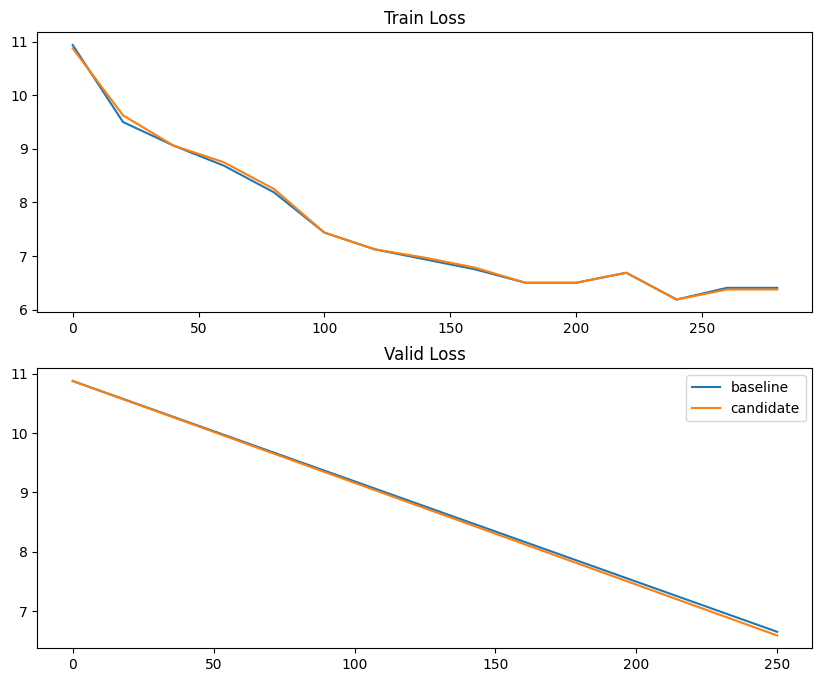

In [18]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.utils import append_to_csv
from jaxpt.train import parallel_train_step


baseline_train_losses, candidate_train_losses = [], []
baseline_val_losses, candidate_val_losses = [], []
append_to_csv(log_dir / f"{baseline_run_dirname}_train.csv", ["step", "lr", "loss", "norm", "time", "tokens_processed", "tokens_per_sec"])
append_to_csv(log_dir / f"{baseline_run_dirname}_valid.csv", ["step", "loss"])
append_to_csv(log_dir / f"{candidate_run_dirname}_train.csv", ["step", "lr", "loss", "norm", "time", "tokens_processed", "tokens_per_sec"])
append_to_csv(log_dir / f"{candidate_run_dirname}_valid.csv", ["step", "loss"])

baseline.train()
candidate.train()

try:
  while step < trconf.max_steps:
    start = time.time()
    batch, target = train_dl()

    # baseline step
    baseline_avg_loss, baseline_avg_grads = parallel_train_step(baseline, baseline_optimizer, batch, target)
    baseline_avg_loss.block_until_ready()

    # candidate step
    candidate_avg_loss, candidate_avg_grads = parallel_train_step(candidate, candidate_optimizer, batch, target)
    candidate_avg_loss.block_until_ready()

    # compute stats
    baseline_avg_loss = jnp.float32(baseline_avg_loss[0])
    candidate_avg_loss = jnp.float32(candidate_avg_loss[0])

    lr = warmup_with_cosine_decay_schedule(step)
    norm = 0 # norm[0]|
    iter_time = time.time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      baseline_train_losses.append((step, baseline_avg_loss))
      candidate_train_losses.append((step, candidate_avg_loss))
      append_to_csv(log_dir / f"{baseline_run_dirname}_train.csv", [step, lr, baseline_avg_loss, norm, iter_time*1000, tokens_processed, tokens_per_sec])
      append_to_csv(log_dir / f"{candidate_run_dirname}_train.csv", [step, lr, candidate_avg_loss, norm, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | baseline loss: {baseline_avg_loss:0.4f} | "
            f"candidate loss: {candidate_avg_loss:0.4f} | "
            f"tokens processed: {tokens_processed:,} | "
            f"tok/sec: {tokens_per_sec:,.2f}")#, end="\r")
    if step % trconf.eval_interval == 0:
      baseline_valid_loss, baseline_completions = evaluate(baseline)
      baseline_valid_loss = jnp.float32(baseline_valid_loss)
      baseline_val_losses.append((step, baseline_valid_loss))
      append_to_csv(log_dir / f"{baseline_run_dirname}_valid.csv", [step, baseline_valid_loss])
      candidate_valid_loss, candidate_completions = evaluate(candidate)
      candidate_valid_loss = jnp.float32(candidate_valid_loss)
      candidate_val_losses.append((step, jnp.float32(candidate_valid_loss)))
      append_to_csv(log_dir / f"{baseline_run_dirname}_valid.csv", [step, candidate_valid_loss])
      print(f"baseline valid loss: {baseline_valid_loss:0.4f} |"
            f"candidate valid loss: {candidate_valid_loss:0.4f} "  )

      print("Baseline completions:")
      for completion in baseline_completions:
        print(completion)
      print("Candidate completions")
      for completion in candidate_completions:
        print(completion)
    #if step > 0 and trconf.checkpoint_interval > 0 and step % trconf.checkpoint_interval == 0:
      #save_checkpoint(m, step)

    step += 1

except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

baseline_valid_loss, baseline_completions = evaluate(baseline)
baseline_valid_loss = jnp.float32(baseline_valid_loss)
candidate_valid_loss, candidate_completions = evaluate(candidate)
candidate_valid_loss = jnp.float32(candidate_valid_loss)
print(f"baseline valid loss: {baseline_valid_loss:0.4f} | "
      f"candidate valid loss: {candidate_valid_loss:0.4f}")
print(f"baseline completions")
for completion in baseline_completions:
  print(completion)
print(f"candidate completions")
for completion in candidate_completions:
  print(completion)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot([x[0] for x in baseline_train_losses], [x[1] for x in baseline_train_losses], label="baseline")
axes[0].plot([x[0] for x in candidate_train_losses], [x[1] for x in candidate_train_losses], label="candidate")
axes[0].set_title("Train Loss")

axes[1].plot([x[0] for x in baseline_val_losses], [x[1] for x in baseline_val_losses], label="baseline")
axes[1].plot([x[0] for x in candidate_val_losses], [x[1] for x in candidate_val_losses], label="candidate")
axes[1].set_title("Valid Loss")

plt.legend()
plt.savefig(log_dir / f"{baseline_run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
